This notebook is my attempt to work through the simple math related to the readout production and detection of signals.

I'm being sloppy about terminology -- the FPGA implements a polyphase filter bank, which I'm calling an FFT.

In [1]:
from kid_readout.utils import roach_interface, roach_utils

In [2]:
ri = roach_interface.RoachBaseband()

Loaded ROACH state from /home/data/roach_config.npz


I'll use capital $F$ to denote frequencies that relate to the ADC sampling, and lowercase $f$ to denote frequencies that relate to the demodulated signal. The ADC has 12 bits that divide its input range into $2^{12} = 4096$ bins.

This is the ADC sample rate:

In [3]:
F_ADC = 1e6 * ri.fs
F_ADC  # in Hz

512000000.0

The Nyquist frequency for the ADC is half its sampling frequency, or 256 MHz. A hardware filter with a cutoff around 210 MHz in front of the ADC reduces aliasing.

This is $N$, the number of real samples that go into each FFT:

In [4]:
N = 2 * ri.nfft
N

32768

This number varies between the various Roach firmware builds and corresponding classes, but it's always a power of two:

In [5]:
np.log2(N)

15.0

The rate at which complex FFT samples are produced is

In [6]:
FFT_output_rate = F_ADC / N
FFT_output_rate  # in Hz

15625.0

This output rate is the inverse of the length of each timestream:

In [7]:
T = 1 / FFT_output_rate
T  # in s

6.4e-05

Each FFT produces $N$ complex points corresponding to frequencies between $-F_\mathrm{sample} / 2$ and (almost) $F_\mathrm{sample} / 2$, but because the input signal from the ADC is real the negative frequency components are the conjugates of the positive frequency components. The independent output of each FFT thus consists of $N / 2$ complex samples representing frequencies from 0 to $F_\mathrm{sample} / 2$.

This bandwidth is divided into $N / 2$ bins, so the frequency resolution or bin width is
$$
\delta
  =
  \frac{F_\mathrm{sample} / 2}{N / 2}
  =
  \frac{F_\mathrm{sample}}{N}
$$

In [8]:
delta = F_ADC / N
delta

15625.0

The operation of filtering conserves information in the sense that the input and output information rates are the same. The real input signal at $F_\mathrm{sample}$ is transformed into $N / 2$ complex samples output at frequency $F_\mathrm{sample} / N$, which is equivalent to
$$
2 \frac{N}{2} \frac{F_\mathrm{sample}}{N}
  =
  F_\mathrm{sample}
$$
real points per unit time.

In practice, the signals from most of the bins are discarded since we are interested in the bins that contain active detectors. We can consider the stream of complex samples in each bin as a complex signal produced at the FFT output rate that contains frequency information about that bin.

For each bin, the Nyquist frequency of this FFT output signal is half the output rate:

In [9]:
f_Nyquist = FFT_output_rate / 2
f_Nyquist

7812.5

We read out each detector using a single probe signal. This signal is amplitude modulated by the KID, so the detector information appears in sidebands of the carrier frequency. The Roach can use the carrier frequency to demodulate the data. I don't yet understand how this calculation works or if any bandwidth is lost in the demodulation.

The probe tones are generated by a 16-bit DAC with a 512 MHz output rate, the same as the ADC sample rate. The analog signal generation involves playing a single cycle of the digital waveform over and over. For this waveform to be contained in a reasonable amount of memory, the frequency components in the waveform must be multiples of a fundamental frequency.

In [10]:
F_DAC = F_ADC

The number of samples in the waveform is easy to adjust. For this waveform, it is

In [11]:
ri.tone_nsamp

2097152

In [12]:
np.log2(ri.tone_nsamp)

21.0

The frequency resolution is thus

In [13]:
f_tone = F_DAC / ri.tone_nsamp
f_tone

244.140625

This is currently much smaller than an FFT bin, so we have many choices of tones in each bin. The limit for the tone frequency resolution is set by the available memory of the Roach, which is currently 256 MB or $2^{28}$ bytes.

Each tone frequency corresponds to an integer tone bin, and these range from 0 to one less than the number of waveform samples. The frequencies are given by

In [14]:
tone_frequencies = f_tone * ri.tone_bins
tone_frequencies / 1e6  # in MHz

array([[  96.05126953,  101.95092773,  108.85449219,  112.25146484,
         117.2644043 ,  127.77124023,  144.1784668 ,  148.23388672,
         164.0690918 ,  164.3605957 ,  165.39941406,  174.94262695,
         178.92578125,  184.54492188,  188.84960938,  195.69677734],
       [  96.05249023,  101.95214844,  108.85571289,  112.25268555,
         117.265625  ,  127.77246094,  144.1796875 ,  148.23510742,
         164.0703125 ,  164.36181641,  165.40063477,  174.94384766,
         178.92700195,  184.54614258,  188.85083008,  195.69799805],
       [  96.05371094,  101.95336914,  108.85693359,  112.25390625,
         117.2668457 ,  127.77368164,  144.1809082 ,  148.23632812,
         164.0715332 ,  164.36303711,  165.40185547,  174.94506836,
         178.92822266,  184.54736328,  188.85205078,  195.69921875],
       [  96.05493164,  101.95458984,  108.8581543 ,  112.25512695,
         117.26806641,  127.77490234,  144.18212891,  148.23754883,
         164.07275391,  164.36425781,  165.40

Only the lower half of the available output frequency band is below the ADC Nyquist frequency.

To do:

- Understand demodulation
- Understand the FFT bin window response and leakage between bins

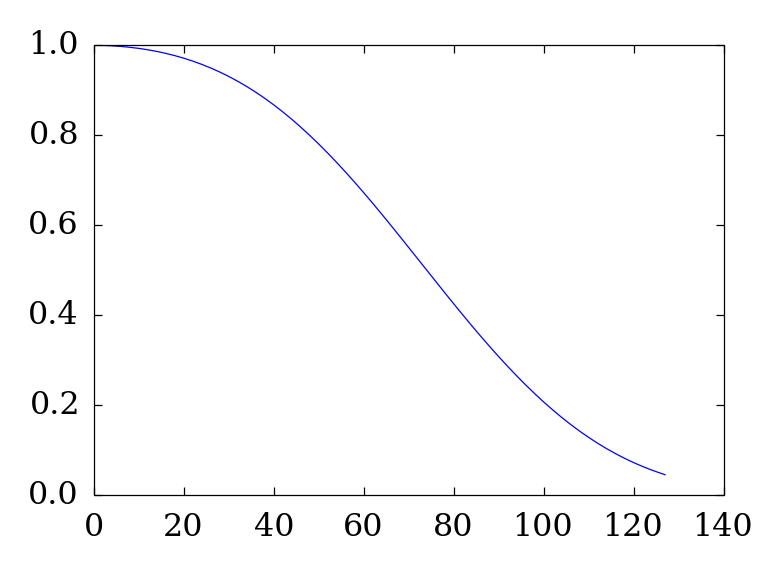

In [16]:
plt.plot(ri._window_mag)

In [17]:
1e6 * 2 * T

64.0